# Part 1: Explore the processed Waymo dataset

In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed and downsampled Waymo dataset (processed data in the `train_and_validation` folder in the data directory `./data/waymo`), respectively. The data frames in the processed tfrecord files only contain the images of the front camera including the associated ground truth annotations for the sake of reducing required storage capacity. As suggested by the task given by Udacity, 3 dedicated tfrecord files have been taken out from the 100 tfrecord files of the overall data set. The rest has been downsampled by the factor of 10 (original frame rate = 10 fps) assuming that subsequent images are very similar, and thus, do not provide that much more additional content for training. Therefore, time distance between two subsequent frames of a sequence used for training or cross-validation is increased. Each raw tfrecord file contains about 200 frames (or more precisely: between 198 or 199 frames). After downsampling by the factor of 10, each processed tfrecord file does not contain more than 20 images. Training and validation set used in this experiment comprise 97 downsampled tfrecord files, and thus, do not contain more than 1940 images.

Certainly, this is far too low to get a good training result. But this is not the main intention in this task. Here, we rather look for the qualitative effects of different configurations when using TensorFlow Object Detection API. Nevertheless, we should have a similar data distribution in both training and validation set. Therefore, this notebook has a second part [Exploratory_Data_Analysis_Part2.ipynb](./Exploratory_Data_Analsyis_Part2.ipynb) where we analyse and compare the object distributions contained in the downsampled training and validation data set with one another. The data split needs to be done inbetween part 1 and part 2.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Enable TensorFlow eager execution mode
tf.compat.v1.enable_eager_execution()

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

from utils import get_dataset
from utils import get_label_map

In [2]:
%matplotlib inline

In [3]:
#tfrecord_filepath = "./data/waymo/processed/*.tfrecord"
tfrecord_filepath = "./data/waymo/training_and_validation/*.tfrecord"
dataset = get_dataset(tfrecord_filepath)

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 97
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


In [4]:
# get object category index and object classname index
category_idx, classname_idx = get_label_map(label_map_path='./label_map.pbtxt')
print("Object category index:     {}".format(category_idx))
print("Object classname index:    {}".format(classname_idx))

# get number of availabel object classes
num_of_object_classes = len(category_idx)
print("Number of object classes:  {}".format(num_of_object_classes))

Object category index:     {1: 'vehicle', 2: 'pedestrian', 4: 'cyclist'}
Object classname index:    {'vehicle': 1, 'pedestrian': 2, 'cyclist': 4}
Number of object classes:  3


In [5]:
#class_color_idx = {1: [0, 0, 1], 2: [1, 0, 0], 4: [0, 1, 0]}
class_color_idx = {1: u'#1f77b4', 2: u'#ff7f0e', 4: u'#2ca02c'}
# create an array with class-based colors
custom_colors = list(class_color_idx.values())
# define custom color palette
custom_color_palette = sns.set_palette(sns.color_palette())

In [6]:
# have a look into element specification of a sample frame
dataset.element_spec

{'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 'source_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'key': TensorSpec(shape=(), dtype=tf.string, name=None),
 'filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'groundtruth_image_confidences': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_verified_neg_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_not_exhaustive_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_boxes': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None),
 'groundtruth_area': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_group_of': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_weights': TensorSpec(shape=(None,), dtype=tf.float32, name=Non

In [7]:
# get image shape for the front camera images
image_height, image_width, color_channels = 0, 0, 0
for frame in dataset.take(1):
    image_height, image_width, color_channels = frame['image'].shape
print(f'image.shape = ({image_height}, {image_width}, {color_channels})')

# get source id, key and filename
print(f"source_id = {frame['source_id'].numpy().decode('utf8')}")
print(f"key = {frame['key'].numpy().decode('utf8')}")
print(f"filename = {frame['filename'].numpy().decode('utf8')}")

image.shape = (640, 640, 3)
source_id = 11928449532664718059_1200_000_1220_000_FRONT_100
key = 
filename = segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord


## Function to display an image and the bounding boxes

The `display_instances` function below takes a batch of frames as input and displays the images of the front camera with their corresponding ground truth bounding boxes. The classes are color coded as follows: vehicles in blue, pedestrians in orange, cyclists in green.

In [8]:
def display_instances(
    batch, label_category_index, label_color_index, num_of_cols=1):
    """
    This function takes a batch from the dataset and displays the image(s) with
    the associated ground truth object bounding boxes.
    
    Remark: TensorFlow Object Detection API uses the following bounding box format
            [ymin, xmin, ymay, xmax] = gt_bbox
    
    args:
        - batch [tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter]: batch of images taken 
          from a tensorflow dataset
        - label_category_index [dict]: label category index 
        - label_color_index [dict]: label category color index
        - num_of_cols [int]: number of colums of subplot array, defaults to 1
    """
    # get batch size
    batch_size = max([idx for idx, _ in enumerate(batch)]) + 1
    if batch_size == 1:
        cols = 1
        rows = 1
    else:
        cols = num_of_cols
        if batch_size % cols:
            rows = batch_size // cols + 1
        else:
            rows = batch_size // cols
    
    fig, ax = plt.subplots(rows, cols, figsize=(cols*10,rows*10))
    # switch off axis labels
    if batch_size == 1:
        ax.axis('off')
    elif cols == 1:
        for row_idx in range(rows):
            ax[row_idx].axis('off')
    else:
        for row_idx in range(rows):
            for col_idx in range(cols):
                ax[row_idx, col_idx].axis('off')
    # plot images with ground truth obect bounding boxes and class labels
    for idx, frame in enumerate(batch):        
        # get image frame
        image = frame['image'].numpy()
        # get image shape
        h, w, _ = image.shape
        # get ground truth object bounding boxex
        gt_bboxes = frame['groundtruth_boxes'].numpy()
        # get ground truth object class indices
        gt_classes = frame['groundtruth_classes'].numpy()
        # resize the normalized object bounding boxes
        gt_bboxes[:, [0, 2]] *= h  # resize ymin and ymax
        gt_bboxes[:, [1, 3]] *= w  # resize xmin and xmax
        # get row and column index of current plot
        row_idx = idx // cols
        col_idx = idx % cols
        # plot current image
        if batch_size == 1:
            ax.imshow(image)
        elif cols == 1:
            ax[row_idx].imshow(image)
        else:
            ax[row_idx, col_idx].imshow(image)
        # plot ground truth object bounding boxes for the current image
        for gt_bbox, gt_class in zip(gt_bboxes, gt_classes):
            # get the color mapping to the ground truth object class
            gt_class_color = label_color_index[gt_class]
            # add ground truth object bounding boxes
            ymin, xmin, ymax, xmax = gt_bbox
            rect = Rectangle(
                (xmin, ymin),
                xmax-xmin,
                ymax-ymin,
                facecolor='none',
                edgecolor=gt_class_color,
                linewidth=2,
            )
            if batch_size == 1:
                ax.add_patch(rect)
            elif cols == 1:
                ax[row_idx].add_patch(rect)
            else:
                ax[row_idx, col_idx].add_patch(rect)
            # add ground truth object class names
            
            gt_class_name = label_category_index[gt_class]
            text_offset_xmin = 2
            text_offset_ymin = 8
            if batch_size == 1:
                ax.text(
                    xmin+text_offset_xmin,
                    ymin+text_offset_ymin,
                    gt_class_name,
                    color=gt_class_color,
                )
            elif cols == 1:
                ax[row_idx].text(                    
                    xmin+text_offset_xmin,
                    ymin+text_offset_ymin,
                    gt_class_name,
                    color=gt_class_color,
                )
            else:
                ax[row_idx, col_idx].text(
                    xmin+text_offset_xmin,
                    ymin+text_offset_ymin,
                    gt_class_name,
                    color=gt_class_color,
                )
    plt.tight_layout()
    plt.show()

## Display a batch of random images to get a first impression

By applying the methods `take` and `shuffle` on the dataset, we pick a batch of 10 random images from the dataset and display the images of the front camera including the color coded ground truth bounding boxes of the objects that are present in the images using above `display_instances` function.

In [9]:
BATCH_SIZE = 10
BUFFER_SIZE = 100
batch = dataset.shuffle(BUFFER_SIZE).take(BATCH_SIZE)
batch_dim = max([index for index, _ in enumerate(batch.as_numpy_iterator())]) + 1
batch_dim

10

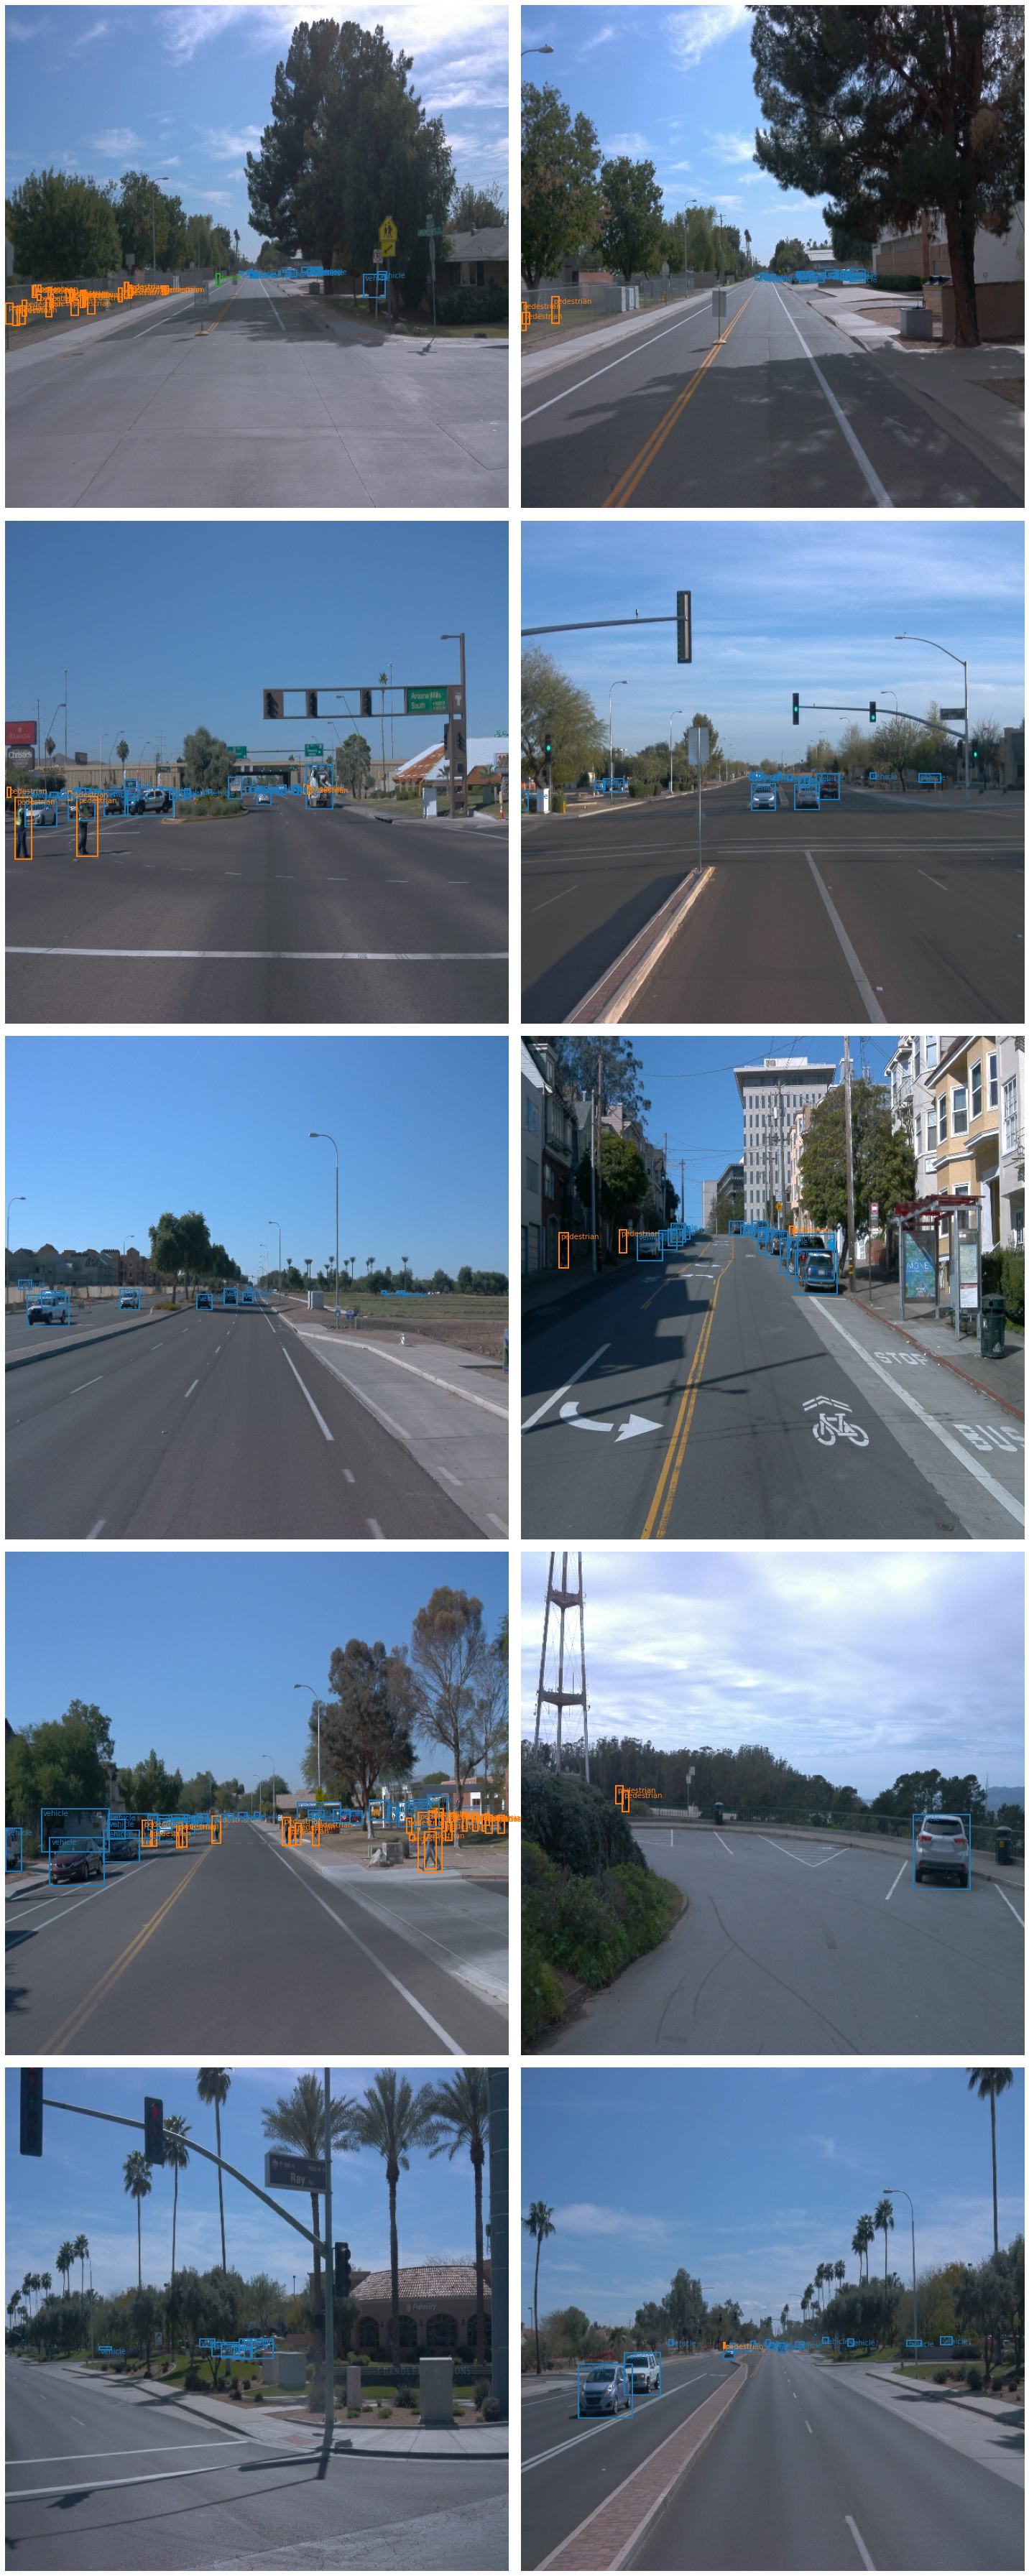

In [10]:
# display a batch of images
display_instances(batch, category_idx, class_color_idx, num_of_cols=2)

## Additional Explorative Data Analysis (EDA)

In this last part, we perform further steps in analysing the dataset w.r.t. to the number and types of objects in the frames, their bounding box location on images plane, their bounding box sizes and apsect ratios as well as the distribution of image brightness over all frames in the data set.

In [11]:
def get_statistics_from_tf_data_batch(batch, category_index):
    """ Get ground truth data statistics of labeled objects in a selected batch
        from a TensorFlow datast for object detection in color images.
    
    Args:
        batch [batch of tf.data.Dataset]: batch of a TensorFlow dataset
        category_index [dict]: object class category index by object class id
    
    Returns:
        df_frame_stats [pandas.DataFrame]: dataframe holding frame statistics
        df_obj_stats [pandas.DataFrame]: dataframe holding object statistics
    """
    # column names for frame statistics
    df_frame_stats_columns = [
        'frame_idx',
        'source_id',
        'img_shape',
        'avg_brightness',
        'obj_counts',
    ]
    # column names for object statistics
    df_obj_stats_columns = [
        'frame_idx',
        'obj_idx',
        'gt_class_idx',
        'gt_class_name',
        'gt_bbox_x_center',
        'gt_bbox_y_center',
        'gt_bbox_width',
        'gt_bbox_height',
        'gt_bbox_area',
        'gt_bbox_aspect_ratio',
    ]
    
    # init lists for frame and object statistics
    frame_stats = []
    obj_stats = []
    
    # loop over all frames in the batch to collect frame statistics
    for frame_idx, frame in enumerate(batch):
        # get source id (convert from bytes to string)
        source_id = frame['source_id'].numpy().decode("utf-8")
        # get image
        image = frame['image'].numpy()
        # get image shape
        h, w, c = image.shape
        # calculate average brightness over all pixels
        avg_brightness = np.sum(image)/(h*w*c)
        # get ground truth object bounding boxes
        gt_bboxes = frame['groundtruth_boxes'].numpy()
        # get ground truth object class indices
        gt_classes = frame['groundtruth_classes'].numpy()
        # resize the normalized object bounding boxes
        gt_bboxes[:, [0, 2]] *= h  # resize ymin and ymax
        gt_bboxes[:, [1, 3]] *= w  # resize xmin and xmax
        # reset framewise object counts by index
        framewise_obj_counts = {}
        for key in category_index.keys():
            framewise_obj_counts[key] = 0
        
        # loop over all labeled ground truth objects in this frame to collect object statistics
        for obj_idx, (gt_class, gt_bbox) in enumerate(zip(gt_classes, gt_bboxes)):
            # get ground truth object class name
            gt_class_name = category_index[gt_class]
            # get ground truth object bounding box coordinates
            ymin, xmin, ymax, xmax = gt_bbox
            # get ground truth object bounding box center coordinates
            x_center = int(xmin + xmax)/2
            y_center = int(ymin + ymax)/2
            # get width and height of the ground truth bounding box
            width = xmax - xmin
            height = ymax - ymin
            # get bounding box area
            area = width * height
            # get bounding box aspect ratio by width
            if height == 0:
                aspect_ratio = np.nan
            else:
                aspect_ratio = width / height
            # increment framewise object counts by index
            framewise_obj_counts[gt_class] += 1
            # create and append a new row for this object in this frame
            new_row_obj_stats = [
                frame_idx,
                obj_idx,
                gt_class,
                gt_class_name,
                x_center,
                y_center,
                width,
                height,
                area,
                aspect_ratio,
            ]
            obj_stats.append(new_row_obj_stats)
        
        # create and append an new row for this frame
        frame_stats_next_row = [
            frame_idx,
            source_id,
            [h, w, c],
            avg_brightness,
            framewise_obj_counts,
        ]
        frame_stats.append(frame_stats_next_row)
    
    # print message
    print("Total number of processed frames in batch: {}".format(frame_idx+1))
    # create data frame holding frame statistics
    df_frame_stats = pd.DataFrame(frame_stats, columns=df_frame_stats_columns)
    # create data frame holding object statistics
    df_obj_stats = pd.DataFrame(obj_stats, columns=df_obj_stats_columns)
    
    # return dataframes
    return df_frame_stats, df_obj_stats

In [12]:
# take a large sample batch
batch_size = 1000
batch = dataset.shuffle(10*batch_size).take(batch_size)

In [13]:
# get data statistics of the selected batch
df_frame_stats, df_obj_stats = get_statistics_from_tf_data_batch(batch, category_idx)

Total number of processed frames in batch: 1000


In [14]:
df_frame_stats.head()

frame_idx                                         source_id      img_shape  \
0          0   1146261869236413282_1680_000_1700_000_FRONT_190  [640, 640, 3]   
1          1  11928449532664718059_1200_000_1220_000_FRONT_140  [640, 640, 3]   
2          2  10599748131695282446_1380_000_1400_000_FRONT_120  [640, 640, 3]   
3          3    10723911392655396041_860_000_880_000_FRONT_110  [640, 640, 3]   
4          4  11392401368700458296_1086_429_1106_429_FRONT_160  [640, 640, 3]   

   avg_brightness            obj_counts  
0       85.578057  {1: 25, 2: 10, 4: 0}  
1      102.768319  {1: 32, 2: 11, 4: 0}  
2      100.080734  {1: 10, 2: 17, 4: 0}  
3      121.546778   {1: 28, 2: 9, 4: 0}  
4      106.772993   {1: 36, 2: 0, 4: 0}

In [15]:
df_obj_stats.head()

frame_idx  obj_idx  gt_class_idx gt_class_name  gt_bbox_x_center  \
0          0        0             2    pedestrian             216.0   
1          0        1             2    pedestrian             224.5   
2          0        2             2    pedestrian             296.0   
3          0        3             2    pedestrian             140.0   
4          0        4             1       vehicle             391.5   

   gt_bbox_y_center  gt_bbox_width  gt_bbox_height  gt_bbox_area  \
0             379.5      42.948120      121.581055   5221.677734   
1             360.0      22.316742       91.738159   2047.296875   
2             363.5      23.684937       81.634308   1933.503418   
3             385.5      17.895050       81.475098   1458.000977   
4             333.5      81.896179       65.369568   5353.518066   

   gt_bbox_aspect_ratio  
0              0.353247  
1              0.243266  
2              0.290135  
3              0.219638  
4              1.252818

### Object classes and object counts

In [16]:
# get total object counts in the batch by classname
tot_obj_cnts_by_classname = df_obj_stats.gt_class_name.value_counts().to_dict()
print(tot_obj_cnts_by_classname)
tot_obj_cnts_by_classindex = df_obj_stats.gt_class_idx.value_counts().to_dict()
print(tot_obj_cnts_by_classindex)

{'vehicle': 17755, 'pedestrian': 5722, 'cyclist': 141}
{1: 17755, 2: 5722, 4: 141}


In [17]:
num_of_object_classes_in_batch = df_obj_stats.gt_class_name.nunique()
object_classes_in_batch = df_obj_stats.gt_class_name.unique()
object_counts_in_batch = df_obj_stats.gt_class_name.value_counts().to_numpy()
object_percentage_in_batch = 100 * object_counts_in_batch / sum(object_counts_in_batch)
print("Number of object classes in batch:        {} of {}".format(
    num_of_object_classes_in_batch, num_of_object_classes))
print("Object classes in batch:                  {}".format(object_classes_in_batch))
print("Total number of objects in batch:         {}".format(sum(object_counts_in_batch)))
print("Object counts per class in batch:         {}".format(object_counts_in_batch))
print("Percentage of each object class in batch: {} %".format(object_percentage_in_batch))

Number of object classes in batch:        3 of 3
Object classes in batch:                  ['pedestrian' 'vehicle' 'cyclist']
Total number of objects in batch:         23618
Object counts per class in batch:         [17755  5722   141]
Percentage of each object class in batch: [75.17571344 24.22728427  0.59700229] %


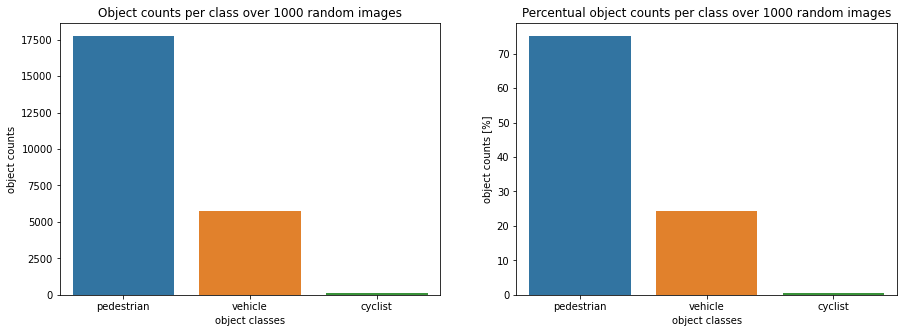

In [18]:
#f, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[8, 4]))
f, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=object_classes_in_batch, y=object_counts_in_batch, palette=custom_color_palette, ax=axs[0])
axs[0].set(
    xlabel='object classes',
    ylabel='object counts',
    title='Object counts per class over {} random images'.format(batch_size),
);
sns.barplot(x=object_classes_in_batch, y=object_percentage_in_batch, palette=custom_color_palette, ax=axs[1])
axs[1].set(
    xlabel='object classes',
    ylabel='object counts [%]',
    title='Percentual object counts per class over {} random images'.format(batch_size),
);
#f.tight_layout()

Percentage of vehicles   = 75.18 %
Percentage of pedestrian = 24.23 %
Percentage of cyclists   =  0.60 %


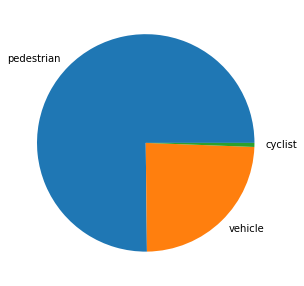

In [19]:
# plot pie graph
f, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.pie(object_counts_in_batch, labels=object_classes_in_batch, colors=custom_color_palette)

# calculate distribution percentage
print("Percentage of vehicles   = {0:5.2f} %".format(object_percentage_in_batch[0]))
print("Percentage of pedestrian = {0:5.2f} %".format(object_percentage_in_batch[1]))
print("Percentage of cyclists   = {0:5.2f} %".format(object_percentage_in_batch[2]))

### Object locations on 2D image plane

In [20]:
# extract object class specific statistics from batch statistics
df_vehicle_stats = df_obj_stats.query('gt_class_idx == 1')
df_pedestrian_stats = df_obj_stats.query('gt_class_idx == 2')
df_cyclist_stats = df_obj_stats.query('gt_class_idx == 4')

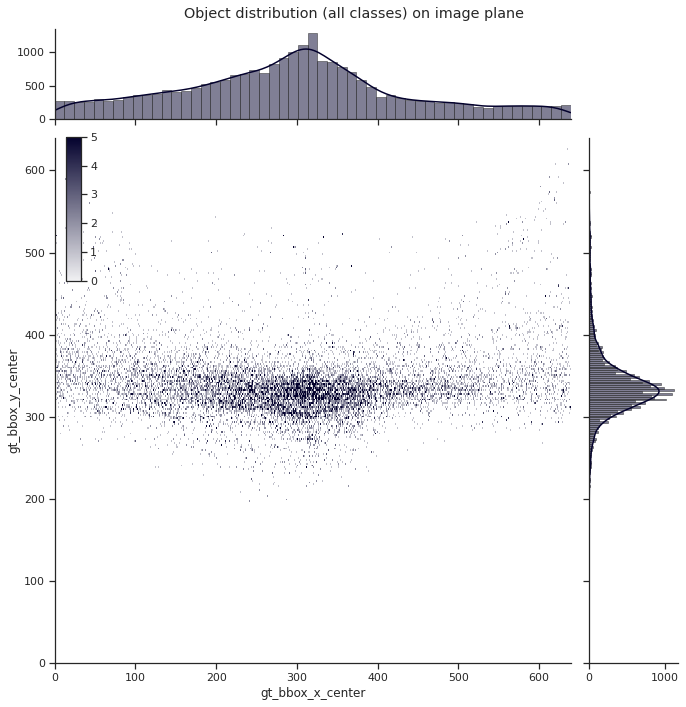

In [21]:
# Distribution of object locations on 2D image plane - all object classes
sns.set_theme(style="ticks") # use a theme with ticks
# create joint plot
g = sns.JointGrid(
    data=df_obj_stats.loc[:, ['gt_bbox_x_center', 'gt_bbox_y_center']],
    x="gt_bbox_x_center",
    y="gt_bbox_y_center",
    height=10,
    space=0.2,
    marginal_ticks=True,
    xlim=(0, image_width),
    ylim=(0, image_height),
)
# create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.1, .6, .02, .2])
# create figure suptitle
g.fig.suptitle("Object distribution (all classes) on image plane")
g.fig.subplots_adjust(top=0.95, right=0.95) # Reduce plot to make room 
# add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax,
)
g.plot_marginals(
    sns.histplot, kde=True, color="#03012d",
    alpha=.5, edgecolor=".2", linewidth=.5,
);

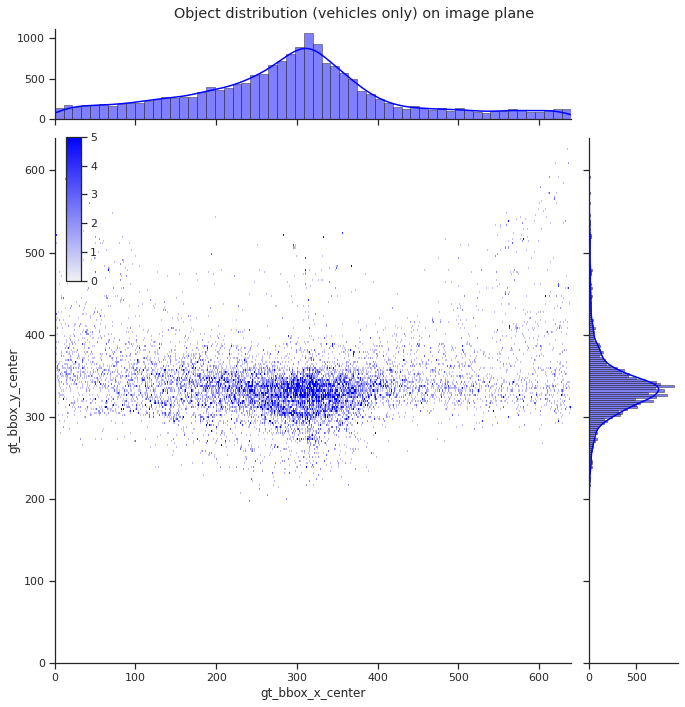

In [22]:
# Distribution of object locations on 2D image plane - vehicles only
sns.set_theme(style="ticks") # use a theme with ticks
# create joint plot
g = sns.JointGrid(
    data=df_vehicle_stats.loc[:, ['gt_bbox_x_center', 'gt_bbox_y_center']],
    x="gt_bbox_x_center",
    y="gt_bbox_y_center",
    height=10,
    space=0.2,
    marginal_ticks=True,
    xlim=(0, image_width),
    ylim=(0, image_height),
)
# create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.1, .6, .02, .2])
# create figure suptitle
g.fig.suptitle("Object distribution (vehicles only) on image plane")
g.fig.subplots_adjust(top=0.95, right=0.95) # Reduce plot to make room 
# add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:blue", pmax=.8, cbar=True, cbar_ax=cax,
)
g.plot_marginals(
    sns.histplot, kde=True, color="blue",
    alpha=.5, edgecolor=".2", linewidth=.5,
);

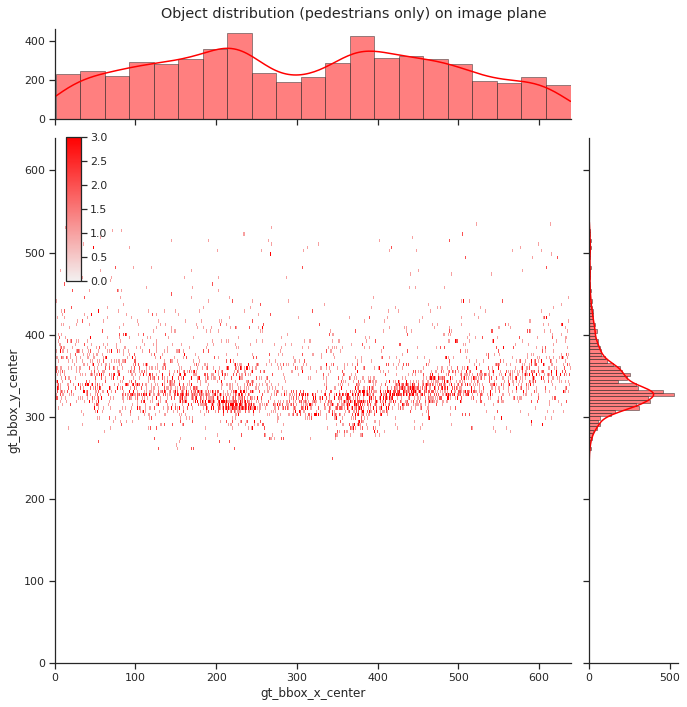

In [23]:
# Distribution of object locations on 2D image plane - pedestrians only
sns.set_theme(style="ticks") # use a theme with ticks
# create joint plot
g = sns.JointGrid(
    data=df_pedestrian_stats.loc[:, ['gt_bbox_x_center', 'gt_bbox_y_center']],
    x="gt_bbox_x_center",
    y="gt_bbox_y_center",
    height=10,
    space=0.2,
    marginal_ticks=True,
    xlim=(0, image_width),
    ylim=(0, image_height),
)
# create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.1, .6, .02, .2])
# create figure suptitle
g.fig.suptitle("Object distribution (pedestrians only) on image plane")
g.fig.subplots_adjust(top=0.95, right=0.95) # Reduce plot to make room 
# add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:red", pmax=.8, cbar=True, cbar_ax=cax,
)
g.plot_marginals(
    sns.histplot, kde=True, color="red",
    alpha=.5, edgecolor=".2", linewidth=.5,
);

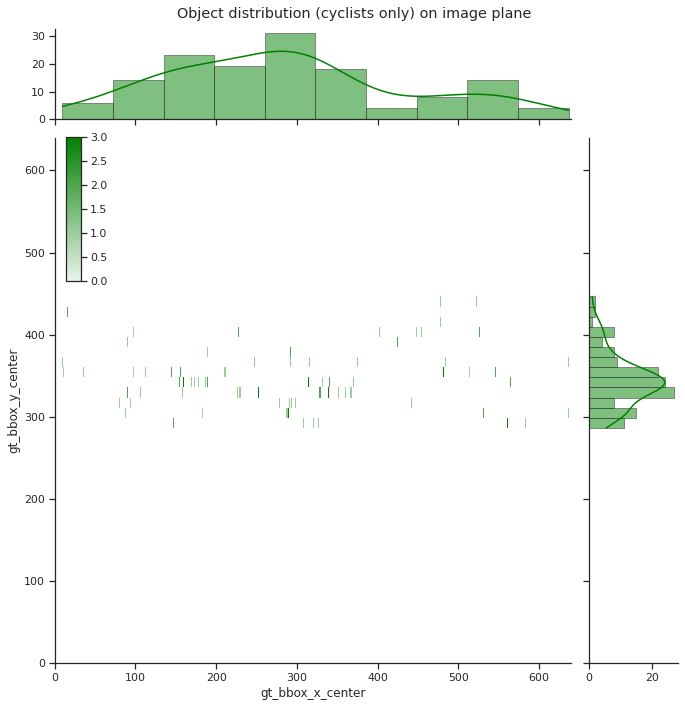

In [24]:
# Distribution of object locations on 2D image plane - cyclists only
sns.set_theme(style="ticks") # use a theme with ticks
# create joint plot
g = sns.JointGrid(
    data=df_cyclist_stats.loc[:, ['gt_bbox_x_center', 'gt_bbox_y_center']],
    x="gt_bbox_x_center",
    y="gt_bbox_y_center",
    height=10,
    space=0.2,
    marginal_ticks=True,
    xlim=(0, image_width),
    ylim=(0, image_height),
)
# create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.1, .6, .02, .2])
# create figure suptitle
g.fig.suptitle("Object distribution (cyclists only) on image plane")
g.fig.subplots_adjust(top=0.95, right=0.95) # Reduce plot to make room 
# add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:green", pmax=.8, cbar=True, cbar_ax=cax,
)
g.plot_marginals(
    sns.histplot, kde=True, color="green",
    alpha=.5, edgecolor=".2", linewidth=.5,
);

### Object properties

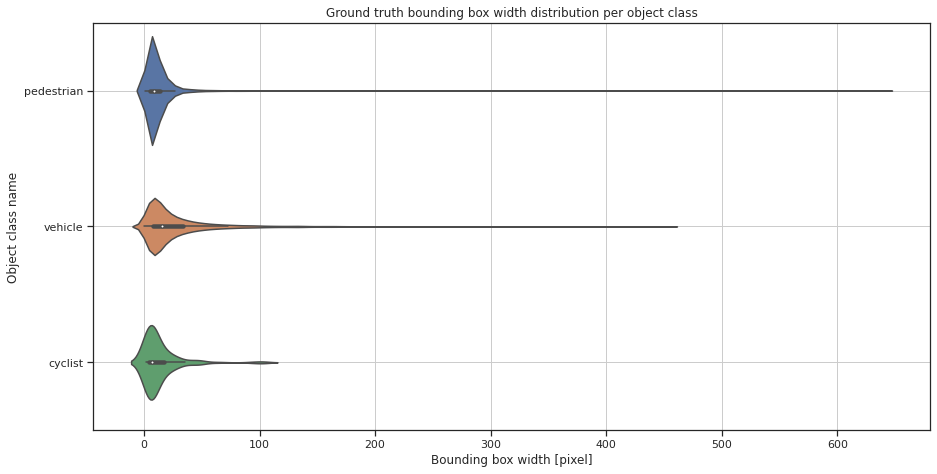

In [25]:
# Distribution of ground truth bounding box width per object class
fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
sns.violinplot(
    x=df_obj_stats.gt_bbox_width, y=df_obj_stats.gt_class_name, data=df_obj_stats,
    palette= custom_color_palette, ax=ax
)
ax.set_xlabel('Bounding box width [pixel]')
ax.set_ylabel('Object class name')
ax.grid(True)
ax.set_title('Ground truth bounding box width distribution per object class');

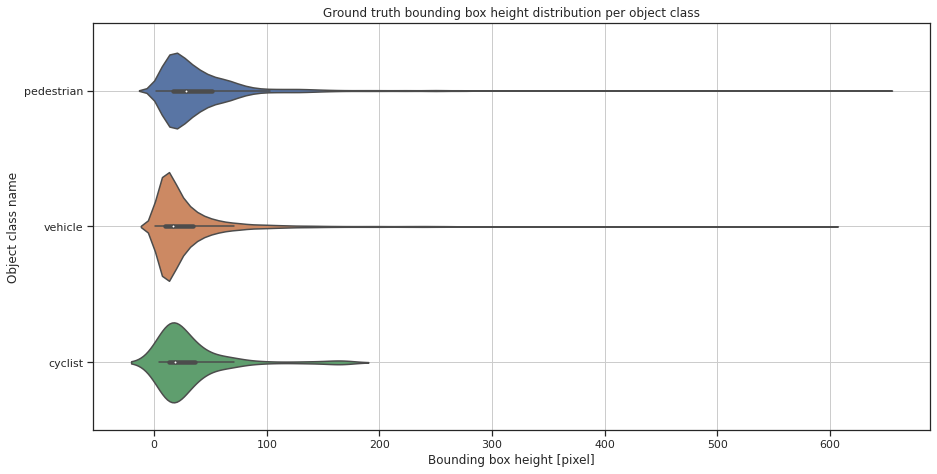

In [26]:
# Distribution of ground truth bounding box height per object class
fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
sns.violinplot(
    x=df_obj_stats.gt_bbox_height, y=df_obj_stats.gt_class_name, data=df_obj_stats,
    palette=custom_color_palette, ax=ax
)
ax.set_xlabel('Bounding box height [pixel]')
ax.set_ylabel('Object class name')
ax.grid(True)
ax.set_title('Ground truth bounding box height distribution per object class');

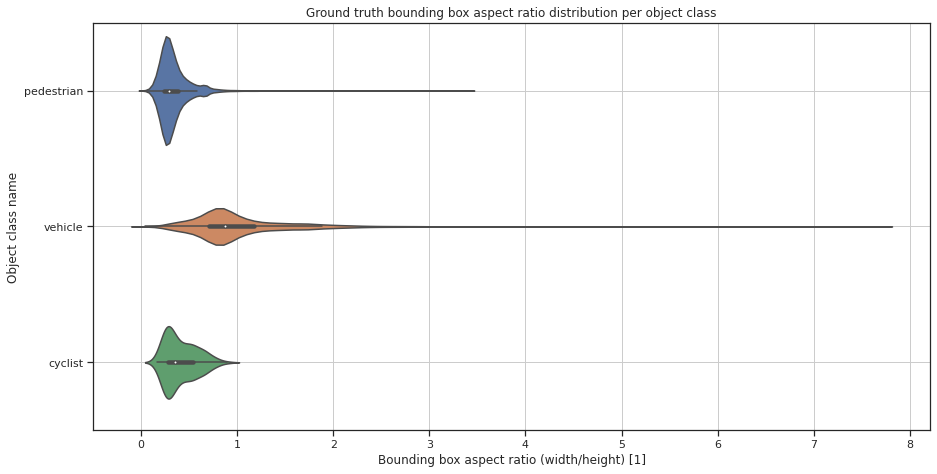

In [27]:
# Distribution of ground truth bounding box aspect ratio per object class
fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
sns.violinplot(
    x=df_obj_stats.gt_bbox_aspect_ratio, y=df_obj_stats.gt_class_name, data=df_obj_stats,
    palette=custom_color_palette, ax=ax
)
ax.set_xlabel('Bounding box aspect ratio (width/height) [1]')
ax.set_ylabel('Object class name')
ax.grid(True)
ax.set_title('Ground truth bounding box aspect ratio distribution per object class');

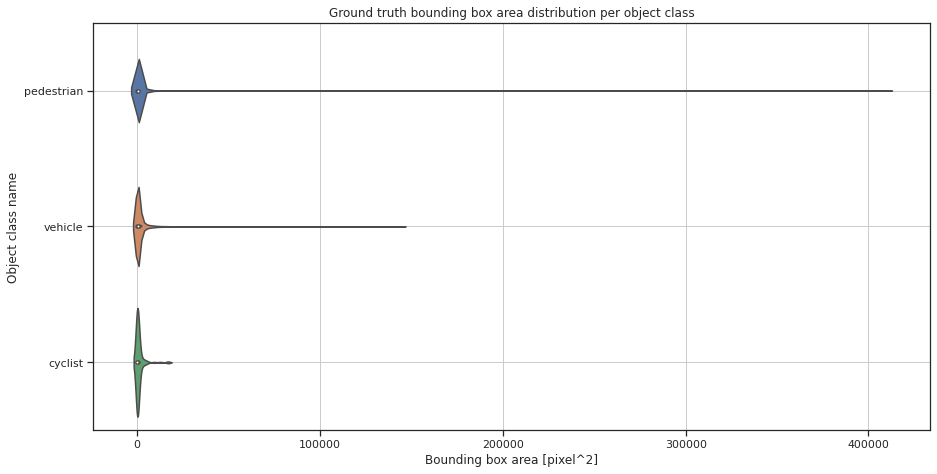

In [28]:
# Distribution of ground truth bounding box area per object class
fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
sns.violinplot(
    x=df_obj_stats.gt_bbox_area, y=df_obj_stats.gt_class_name, data=df_obj_stats,
    palette=custom_color_palette, ax=ax
)
ax.set_xlabel('Bounding box area [pixel^2]')
ax.set_ylabel('Object class name')
ax.grid(True)
ax.set_title('Ground truth bounding box area distribution per object class');

### Object class frequency per frame

In [29]:
df_frame_stats_columns = [
    'frame_idx',
    'source_id',
    'img_shape',
    'avg_brightness',
    'obj_counts',
]

In [30]:
object_counts_per_frame = []
vehicle_counts_per_frame = []
pedestrian_counts_per_frame = []
cyclist_counts_per_frame = []
for frame_idx, obj_cnts in enumerate(df_frame_stats.loc[:, ['obj_counts']].to_numpy()):
    object_counts_per_frame.append(sum(obj_cnts[0].values()))
    vehicle_counts_per_frame.append(obj_cnts[0][classname_idx['vehicle']])
    pedestrian_counts_per_frame.append(obj_cnts[0][classname_idx['pedestrian']])
    cyclist_counts_per_frame.append(obj_cnts[0][classname_idx['cyclist']])

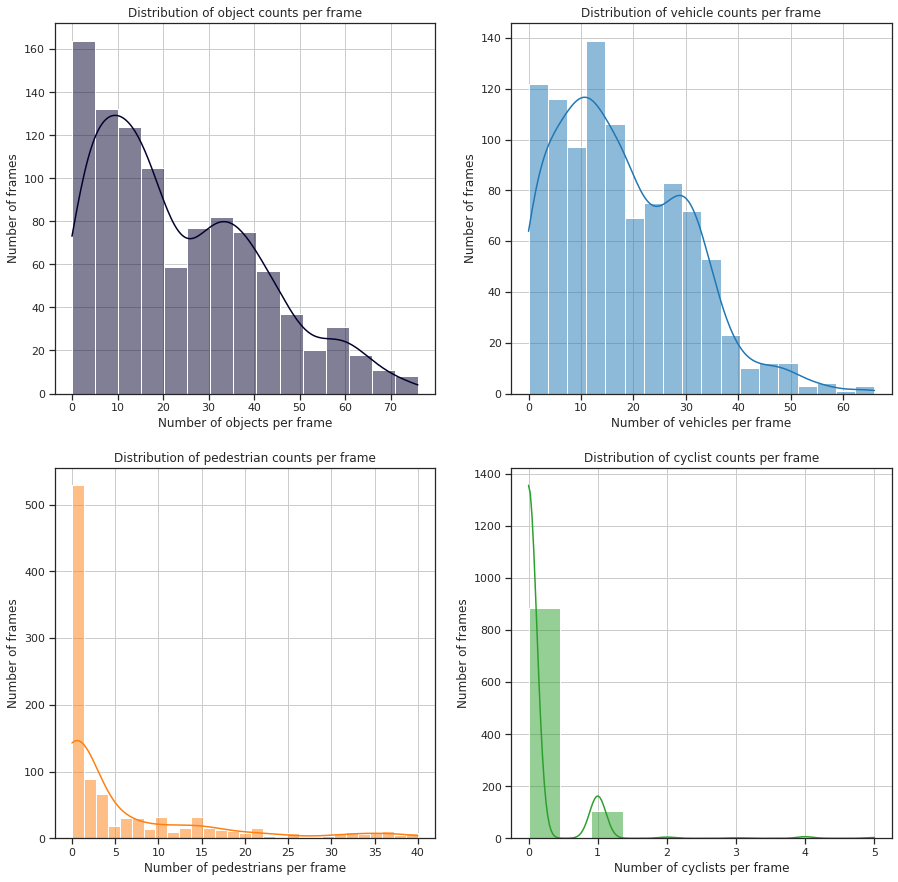

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(data=object_counts_per_frame, kde=True, color="#03012d", ax=axes[0, 0])
axes[0, 0].set(
    xlabel='Number of objects per frame',
    ylabel='Number of frames',
    title='Distribution of object counts per frame'
)
axes[0, 0].grid();
sns.histplot(data=vehicle_counts_per_frame, kde=True, color=custom_colors[0], ax=axes[0, 1])
axes[0, 1].set(
    xlabel='Number of vehicles per frame',
    ylabel='Number of frames',
    title='Distribution of vehicle counts per frame'
)
axes[0, 1].grid();
sns.histplot(data=pedestrian_counts_per_frame, kde=True, color=custom_colors[1], ax=axes[1, 0])
axes[1, 0].set(
    xlabel='Number of pedestrians per frame',
    ylabel='Number of frames',
    title='Distribution of pedestrian counts per frame'
)
axes[1, 0].grid();
sns.histplot(data=cyclist_counts_per_frame, kde=True, color=custom_colors[2], ax=axes[1, 1])
axes[1, 1].set(
    xlabel='Number of cyclists per frame',
    ylabel='Number of frames',
    title='Distribution of cyclist counts per frame'
)
axes[1, 1].grid();

### Average image brightness

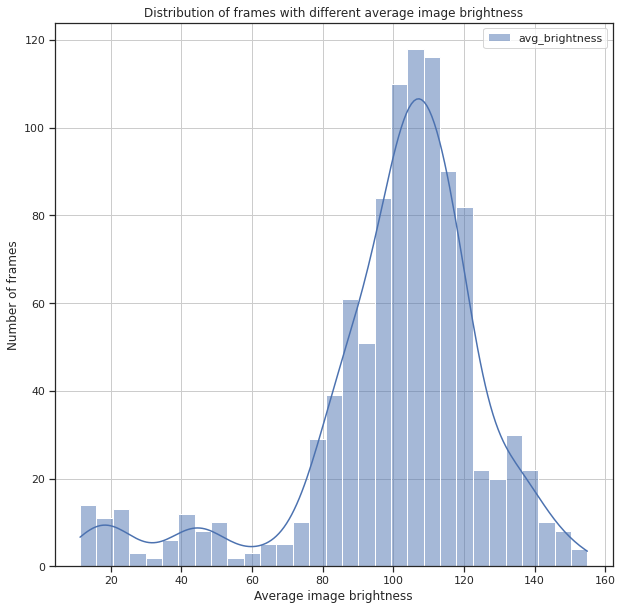

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(data=df_frame_stats.loc[:, ['avg_brightness']], kde=True, ax=ax)
ax.set(
    xlabel='Average image brightness',
    ylabel='Number of frames',
    title='Distribution of frames with different average image brightness'
)
ax.grid();